<a href="https://colab.research.google.com/github/kimheeseo/python/blob/main/p_137_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**학습 알고리즘 구현하기**

In [2]:
# 전제
# 신경망에는 적응 가능한 가중치와 편햐이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 합니다.

# 1단계: 미니배치
# 훈련 데이터 중 일부를 무작위로 가져옵니다. 이렇게 선별한 데이터를 미니배치라 하며, 그 미니배치의 손실 함수 값을 줄이는 것이 목표

# 2단계: 기울기 산충
# 미니배치의 손실 함수 값을 줄이기 위해, 각 가중치 매개변수의 기울기를 구합니다.

# 3단계: 매개변수 갱신
# 가중치 매개변수를 기울기 방향으로 아주 조금 갱신합니다.

# 4단계: 반복
# 1~3단계를 반복합니다.

# stochastic gradient descent: SGD
# 데이터를 미니배치로 무작위로 선정하기 때문에, 확률적 경사하강법
# 확률적으로 무작위로 골라낸 데이터에 대해 수행하는 경사 하강법.

In [3]:
import numpy as np

def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val

    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)

        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val
        it.iternext()

    return grad

In [4]:
# coding: utf-8
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros_like(x)
    grad[x>=0] = 1
    return grad


def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)


def sum_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

**2층 신경망 클래스 구현하기**

In [5]:
import sys, os
sys.path.append(os.pardir)

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):

      # 가중치 초기화
      self.params = {}
      self.params['w1'] = weight_init_std * np.random.randn(input_size, hidden_size)
      self.params['b1'] = np.zeros(hidden_size)
      self.params['w2'] = weight_init_std * np.random.randn(hidden_size, output_size)
      self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
      w1,w2 = self.params['w1'], self.params['w2']
      b1, b2 = self.params['b1'], self.params['b2']

      a1=np.dot(x,w1)+b1
      z1=sigmoid(a1)
      a2=np.dot(z1,w2)+b2
      y=softmax(a2)
      return y

    def loss(self, x, t):
      y=self.predict(x)
      return cross_entropy_error(y,t)

    def accuracy(self, x, t):
      y=self.predict(x)
      y=np.argmax(y, axis=1)
      t=np.argmax(t, axis=1)

      accuracy=np.sum(y==t)/float(x.shape[0])
      return accuracy

    def numerical_gradient(self, x,t):
      loss_w=lambda W:self.loss(x,t)

      grads={}
      grads['w1']=numerical_gradient(loss_w, self.params['w1'])
      grads['w2']=numerical_gradient(loss_w, self.params['w2'])

      grads['b1']=numerical_gradient(loss_w, self.params['b1'])
      grads['b2']=numerical_gradient(loss_w, self.params['b2'])

      return grads

In [6]:
net=TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['w1'].shape)
print(net.params['b1'].shape)
print(net.params['w2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [7]:
x=np.random.rand(100,784) # 더미 입력 데이터 (100장 분량)
y=net.predict(x)

# grads 변수: parmas 변수에 대응하는 각 매개변수의 기울기가 저장.

In [8]:
# numerical_gradient() 메서드를 사용해 기울기를 계산하면 grads 변수에 기울기 정보가 저장됩니다.
x=np.random.rand(100,784) # 손글씨 숫자 인식에서는 크기가 28x28인 입력 이미지가 784개
t=np.random.rand(100,10)

grads=net.numerical_gradient(x,t)

grads['w1'].shape
grads['b1'].shape
grads['w2'].shape
grads['b2'].shape

# loss(self, x, t): 손실함수의 값을 계산하는 메서드
# predict()의 결과와 정답 레이블(t)을 바탕으로 교차 엔트로피 오차를 구하도록 구현.

(10,)

**미니 배치 학습 구현하기**

In [9]:
import numpy as np
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test)=mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
x_train.shape
x_train=x_train.reshape(60000,784)

In [11]:
x_test.shape
x_test=x_test.reshape(10000,784)

In [12]:
train_loss_list=[]

# 하이퍼파라미터
iters_num=200 # 반복횟수
train_size=x_train.shape[0]
batch_size=100 # 미니배치 크기
learning_rate=0.1

In [13]:
network=TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [14]:
for i in range(iters_num):
  #print(f"{i}번째 반복입니다.")
  if i % 10 == 0:
        print(f"{i}번째 반복입니다.")
  # 미니배치 획득
  batch_mask=np.random.choice(train_size, batch_size)
  x_batch=x_train[batch_mask]
  t_batch=t_train[batch_mask]

  # 기울기 계산
  grad=network.numerical_gradient(x_batch, t_batch)

  # 매개변수 갱신
  for key in ('w1', 'b1', 'w2', 'b2'):
    network.params[key]-=learning_rate*grad[key]

  # 학습 경과 기록
  loss= network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

0번째 반복입니다.
10번째 반복입니다.
20번째 반복입니다.
30번째 반복입니다.
40번째 반복입니다.
50번째 반복입니다.
60번째 반복입니다.
70번째 반복입니다.
80번째 반복입니다.


<ipython-input-4-5975c2ef4f41>:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


90번째 반복입니다.
100번째 반복입니다.
110번째 반복입니다.
120번째 반복입니다.
130번째 반복입니다.
140번째 반복입니다.
150번째 반복입니다.
160번째 반복입니다.
170번째 반복입니다.
180번째 반복입니다.
190번째 반복입니다.


In [15]:
train_loss_list

[2.2407855579502085,
 2.2435027044386815,
 2.2119149501724795,
 2.2092270873720476,
 2.1569960633303764,
 2.1435180393336326,
 2.139918614285415,
 2.1156830502193853,
 2.089763075822343,
 2.0415169373825086,
 1.9929719271912274,
 1.9618660089189346,
 1.9738560877469038,
 1.9305872167490694,
 1.913288844473561,
 1.841528990713629,
 1.8978300828536356,
 1.8639556776467514,
 1.810420282494494,
 1.7545753786193146,
 1.7329530162234388,
 1.78691732689174,
 1.6644344210804558,
 1.6839267752128049,
 1.6738943463040061,
 1.661029518480696,
 1.5553898974540936,
 1.5598579420442282,
 1.6014865078096474,
 1.5920862241950173,
 1.5347545257094,
 1.5211460542979216,
 1.6497327625742928,
 1.4797421833488267,
 1.477677201444433,
 1.524596945088225,
 1.4880996117136511,
 1.4662528972996243,
 1.3630153629618311,
 1.3932193302455402,
 1.2236635268889478,
 1.4222652416761872,
 1.3448789542098027,
 1.255742073594857,
 1.3564475581644246,
 1.1856046700240481,
 1.363884075757983,
 1.4148779143785515,
 1.2763

In [18]:
x = list(range(1, 201))

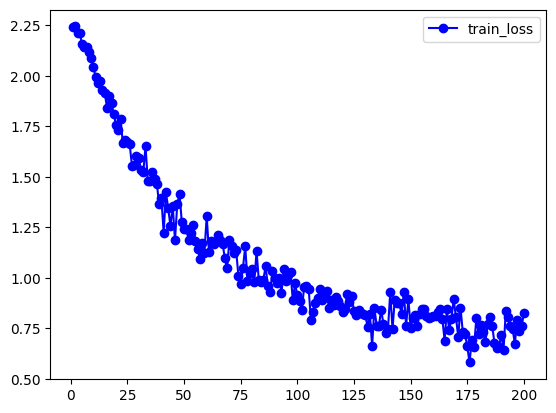

In [19]:
x = list(range(1, 201))
import matplotlib.pyplot as plt
plt.plot(
    x,  # x축 데이터
    train_loss_list,  # y축 데이터
    color='blue',  # 선 색깔
    marker='o',  # 꼭짓점 설정
    linestyle='solid',  # 선 스타일 설정
    label='train_loss'  # 범례
)
plt.legend()
plt.show()

import pandas as pd

df_train_loss=pd.DataFrame(train_loss_list)
df_train_loss.to_csv('df_train_loss.csv', index=False)

**시험 데이터로 평가하기**

In [21]:
# 1 에폭: 학습에서 훈련 데이터를 모두 소진했을 때의 횟수
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test)=mnist.load_data()
x_test.shape
x_test=x_test.reshape(10000,784)

x_train.shape
x_train=x_train.reshape(60000,784)

In [22]:
import numpy as np
network=TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num=200
train_size=x_train.shape[0]
batch_size=100 # 미니 배치 크기
learning_rate=0.1

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

In [23]:
t_train.shape

(60000,)

In [24]:
# 1에폭탕 반복 수
iter_per_epoch=max(train_size/batch_size, 1)

for i in range(iters_num):
  if i % 10 == 0:
      print(f"{i}번째 반복입니다.")
  # 미니배치 호기득
  batch_mask=np.random.choice(train_size, batch_size)
  x_batch=x_train[batch_mask]
  t_batch=t_train[batch_mask]

  # 기울기 계산
  grad= network.numerical_gradient(x_batch, t_batch)

  # 매개변수 갱신
  for key in ('w1', 'b1', 'w2', 'b2'):
    network.params[key]-=learning_rate*grad[key]

  # 학습 경과 기록
  loss=network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  # 1회폭당 정확도 계산
  if i % iter_per_epoch==0:
    train_acc=network.accuracy(x_train, t_train)
    test_acc=network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("train acc, test acc | "+str(train_acc)+", "+str(test_acc))

In [ ]:
x_train[0]=1

In [ ]:
x = list(range(1, 201))

import matplotlib.pyplot as plt
plt.plot(
    x,  # x축 데이터
    train_loss_list,  # y축 데이터
    color='blue',  # 선 색깔
    marker='o',  # 꼭짓점 설정
    linestyle='solid',  # 선 스타일 설정
    label='train_loss'  # 범례
)

plt.plot(
    x,  # x축 데이터
    test_acc_list,  # y축 데이터
    color='red',  # 선 색깔
    marker='o',  # 꼭짓점 설정
    linestyle='solid',  # 선 스타일 설정
    label='test_loss'  # 범례
)

plt.legend()
plt.show()

import pandas as pd

df_train_loss=pd.DataFrame(train_acc_list)
df_test_loss=pd.DataFrame(test_acc_list)

df_test_loss.to_csv('df_test_loss.csv', index=False)
df_train_loss.to_csv('df_train_loss.csv', index=False)